In [101]:
import pandas as pd
import utils
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics.regression import MeanSquaredError,R2Score
from torchinfo import summary
from sklearn.preprocessing import StandardScaler

In [84]:
featureDF=pd.read_csv('feature.csv')
targetDF=pd.read_csv('target.csv')

In [85]:
featureDF.shape,targetDF.shape

((153290, 5), (153290, 5))

In [86]:
featureDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153290 entries, 0 to 153289
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   일시          153290 non-null  object 
 1   최저기온(°C)    153290 non-null  float64
 2   최고기온(°C)    153290 non-null  float64
 3   일강수량(mm)    153290 non-null  float64
 4   평균 상대습도(%)  153290 non-null  float64
dtypes: float64(4), object(1)
memory usage: 5.8+ MB


In [87]:
featureDF=featureDF.drop(columns=['일시'])
featureDF.head()

,최저기온(°C),최고기온(°C),일강수량(mm),평균 상대습도(%)
0,15.3,23.6,0.0,68.0
1,13.7,23.9,0.0,64.9
2,9.6,22.4,0.0,78.0
3,12.0,21.3,0.0,92.8
4,11.2,22.9,0.1,89.4


In [88]:
#targetDF=targetDF.drop(columns=['일시','평균 상대습도(%)','일강수량(mm)'])
targetDF=targetDF[['최저기온(°C)']]
targetDF.head()

,최저기온(°C)
0,13.7
1,9.6
2,12.0
3,11.2
4,13.8


## 데이터 셋 분리 후 텐서화

In [89]:
SS=utils.SeperateSet(featureDF,targetDF)
X_train,X_val,X_test,y_train,y_val,y_test=SS.run()

In [90]:
print(f'X_train : {X_train.shape} X_val :{X_val.shape} X_test:{X_test.shape}')
print(f'y_train : {y_train.shape} y_val :{y_val.shape} y_test:{y_test.shape}')

X_train : (98105, 4) X_val :(24527, 4) X_test:(30658, 4)
y_train : (98105, 1) y_val :(24527, 1) y_test:(30658, 1)


In [91]:
# scaler=StandardScaler()
# scaler.fit(X_train)
# X_train=pd.DataFrame(scaler.transform(X_train))
# X_val=pd.DataFrame(scaler.transform(X_val))
# X_test=pd.DataFrame(scaler.transform(X_test))


In [92]:
trainDS=utils.MyDataSet(X_train,y_train)
valDS=utils.MyDataSet(X_val,y_val)
testDS=utils.MyDataSet(X_test,y_test)

In [93]:
trainDL=DataLoader(trainDS,batch_size=256)
valDL=DataLoader(valDS,batch_size=len(valDS))

## 모델로딩

In [94]:
model=utils.DynamicsModel(featureDF.shape[1],targetDF.shape[1],nums=[6500])
optimizer=optim.Adam(model.parameters(),lr=1)

In [95]:
summary(model,input_size=X_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DynamicsModel                            [98105, 1]                --
├─Linear: 1-1                            [98105, 6500]             32,500
├─Linear: 1-2                            [98105, 1]                6,501
Total params: 39,001
Trainable params: 39,001
Non-trainable params: 0
Total mult-adds (G): 3.83
Input size (MB): 1.57
Forward/backward pass size (MB): 5102.24
Params size (MB): 0.16
Estimated Total Size (MB): 5103.97

In [96]:
# 스케쥴러
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,patience=10,factor=0.9)

In [97]:
lossf=MeanSquaredError()
scoref=R2Score(num_outputs=targetDF.shape[1])

In [98]:
EPOCH=1000
trainmodel=utils.Train_val(trainDL,valDL,model,optimizer,lossf,scoref)
History=trainmodel.train(EPOCH,scheduler,modelnum='min2')

[1/1000]
train loss 170568854.95861948, train score -3469572.5080189817
val loss 141.59283447265625, val score -1.8175930976867676
scheduler.num_bad_epochs 0/10
[2/1000]
train loss 215.05166519184908, train score -3.2783855802069106
val loss 39.86908721923828, val score 0.20663458108901978
scheduler.num_bad_epochs 0/10
[3/1000]
train loss 36.09059704095125, train score 0.27323563195144135
val loss 38.89542007446289, val score 0.2260097861289978
scheduler.num_bad_epochs 0/10
[4/1000]
train loss 62.08331722021103, train score -0.25255276697377366
val loss 18.781591415405273, val score 0.6262601613998413
scheduler.num_bad_epochs 0/10
[5/1000]
train loss 143182.59133883193, train score -2865.0961344066695
val loss 27.503009796142578, val score 0.4527103900909424
scheduler.num_bad_epochs 1/10
[6/1000]
train loss 48136.26106774062, train score -949.0171621632762
val loss 3710264.25, val score -73830.5234375
scheduler.num_bad_epochs 2/10
[7/1000]
train loss 44490.57314752167, train score -879

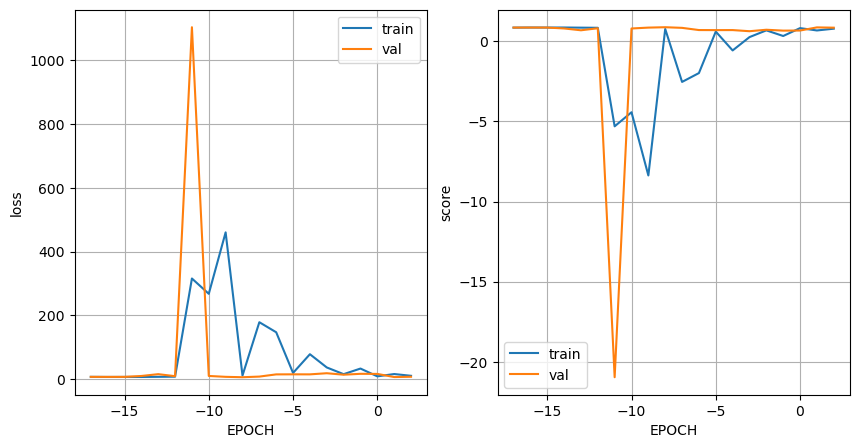

In [99]:
plothistoy=utils.Plot_History(History)
plothistoy.draw(num=20)

In [103]:
testDL=DataLoader(testDS,batch_size=X_test.shape[0])
MIN_Model = torch.load('model/best_modelmin4.pth', weights_only=False)
for feature,target in testDL:
    test_y=MIN_Model(feature)
    loss=lossf(test_y,target)
    score=scoref(test_y,target)
    print(f'test loss {loss}, test score {score}')

test loss 6.102502346038818, test score 0.8772622346878052
